In [8]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

In [145]:
gdd = pd.read_csv("DesMoines_GDD_PredictedGDD.csv")
corn = pd.read_excel("commodity_prices.xlsx", sheet_name="C 1 (Corn)")
soy = pd.read_excel("commodity_prices.xlsx", sheet_name="S 1 (Soy)")

In [146]:
gdd = gdd.rename({"Date" : "date", "Degrees Above 50" : "actual_gdd", "Predicted GDD" : "pred_gdd"}, axis=1)
corn = corn.rename({"Date" : "date", "Last Price" : "corn_price"}, axis=1)
soy = soy.rename({"Date" : "date", "Last Price" : "soy_price"}, axis=1)    
corn = corn.drop(["SMAVG (15)", "Open Interest"], axis=1)
soy = soy.drop(["SMAVG (15)", "Open Interest"], axis=1)

In [147]:
def converter(s):
    parts = s.split()
    integer_part = int(parts[0])
    fraction_part = eval(parts[1])
    result = integer_part + fraction_part
    return result
corn['corn_price'] = corn['corn_price'].apply(lambda x: converter(x) if ' ' in str(x) else x)
soy['soy_price'] = soy['soy_price'].apply(lambda x: converter(x) if ' ' in str(x) else x)


In [148]:
[x for x in range(5, 10)]

[5, 6, 7, 8, 9]

In [99]:
def clean_dates(df):
    GROWING_MONTHS = [x for x in range(5, 10)] #may-sept
    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df["date"].dt.month
    df = df.loc[df["month"].isin(GROWING_MONTHS)]
    df = df.drop(["month"], axis=1)
    return df


gdd = clean_dates(gdd)
corn = clean_dates(corn)
soy = clean_dates(soy)

In [100]:
gdd["deviation"] = gdd["actual_gdd"] - gdd["pred_gdd"]
data = pd.merge(corn, soy, on='date', how='inner')
data = pd.merge(data, gdd, on='date', how='inner')

In [101]:
# data

,date,corn_price,soy_price,actual_gdd,pred_gdd,deviation
0,2022-09-30,677.50,1364.75,9.5,14.9,-5.4
1,2022-09-29,669.50,1410.75,6.0,16.0,-10.0
2,2022-09-28,670.50,1408.75,2.0,16.9,-14.9
3,2022-09-27,667.50,1408.00,8.5,17.1,-8.6
4,2022-09-26,666.25,1411.25,8.0,17.4,-9.4
...,...,...,...,...,...,...
742,2016-05-06,376.00,1026.25,18.5,6.0,12.5
743,2016-05-05,371.75,1003.50,8.0,6.0,2.0
744,2016-05-04,373.25,1024.50,9.0,5.9,3.1
745,2016-05-03,378.25,1021.50,7.0,6.5,0.5


In [128]:

# fuck it better GDD data

iowa = pd.read_csv('36 month Degree day/KDSM_CDD_50F.csv')
iowa = iowa.drop([iowa.columns[2]], axis=1)
iowa["Date"] = pd.to_datetime(iowa["Date"])
iowa["Month"] = iowa["Date"].dt.month
iowa = iowa.loc[iowa["Month"].isin([5,6,7,8,9])]
iowa = iowa.drop(["Month"], axis=1)
iowa = iowa.rename({"Date" : "date"}, axis=1)
iowa["CDD 50"] = iowa["CDD 50"].clip(0, 36)


In [129]:
iowa_merged = pd.merge(iowa, soy, on='date', how='inner')
iowa_merged = pd.merge(iowa_merged, corn, on='date', how='inner')

In [137]:
iowa

,date,CDD 50
90,2020-05-01,15.0
91,2020-05-02,14.6
92,2020-05-03,13.2
93,2020-05-04,3.8
94,2020-05-05,0.0
...,...,...
968,2022-09-26,8.6
969,2022-09-27,8.4
970,2022-09-28,4.1
971,2022-09-29,7.2


In [144]:
# print("corn:", iowa_merged["CDD 50"].diff().corr(iowa_merged["corn_price"].diff()))
# print("soy:", iowa_merged["CDD 50"].diff().corr(iowa_merged["soy_price"].diff()))

print("corn:", iowa_merged["CDD 50"].corr(iowa_merged["corn_price"].diff()))
print("soy:", iowa_merged["CDD 50"].corr(iowa_merged["soy_price"].diff()))

print("soy +1:", iowa_merged["CDD 50"].shift(-1).corr(iowa_merged["soy_price"].diff()))
print("corn +1:", iowa_merged["CDD 50"].shift(-1).corr(iowa_merged["corn_price"].diff()))

print("soy +2:", iowa_merged["CDD 50"].shift(-2).corr(iowa_merged["soy_price"].diff()))
print("corn +2:", iowa_merged["CDD 50"].shift(-2).corr(iowa_merged["corn_price"].diff()))


corn: -0.1259934325900962
soy: -0.1444090111455984
soy +1: -0.17916077381077894
corn +1: -0.16897991129414996
soy +2: -0.1309001966887292
corn +2: -0.13504602441691493


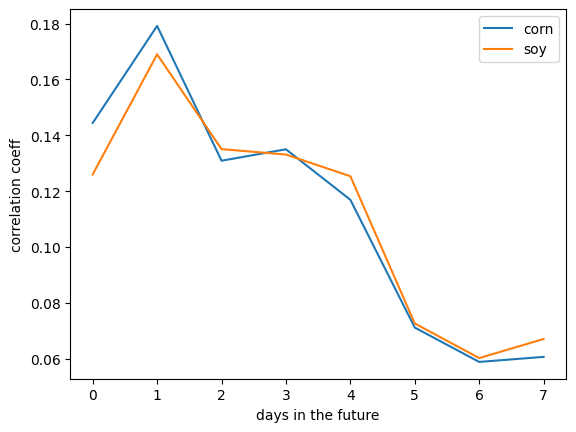

In [162]:
corn_pred = []
soy_pred = []
for x in range(0, 8):
    soy_pred.append(iowa_merged["CDD 50"].shift(-x).corr(iowa_merged["soy_price"].diff()))
    corn_pred.append(iowa_merged["CDD 50"].shift(-x).corr(iowa_merged["corn_price"].diff()))

corn_pred = np.abs(corn_pred)
soy_pred = np.abs(soy_pred)
plt.plot(soy_pred)
plt.plot(corn_pred)
ax = plt.gca()
_  = ax.legend(["corn", "soy"])
_  = ax.set_xlabel("days in the future")
_  = ax.set_ylabel("correlation coeff")



# print(soy_pred, corn_pred)
